In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 

In [51]:
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum
from neurodsp import sim
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum_welch
from neurodsp.plts import plot_time_series, plot_power_spectra
from fooof.bands import Bands

In [3]:
# for this analysis I need the raw data for every patient 

In [4]:
out_path = '/home/icn/Documents/raw_out/RF_32_4/'
BIDS_path = '/home/icn/Documents/BIDS/'

In [5]:
subject_exclude = ['002', '003', '011', '012', '015', '016']
subject_tf_usage = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
#002 - DBS4011 - no locaization possible
#003 - DBS4020 - LEFT due to signal quality
#011 - DBS4037 - STN was not recorded
#012 - DBS4030 - GPi not STN 
#015 - DBS4065 - LEFT due to signal quality

In [6]:
subject_id = []
for patient_test in range(17):
    if patient_test < 10:
        subject_id.append(str('00') + str(patient_test))
    else:
        subject_id.append(str('0') + str(patient_test))


In [7]:
def get_x_y_c(dict_ch, ind_, Con=True, return_z=False):
    
    channels = list(dict_ch.keys())
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    z_choord = np.zeros(len(ind_))
    c_ = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        z_choord[idx] = choord[2]
        
        #wähle den contralateralen channel aus
        mov_channels = dict_ch[channels[ind_ch]]['mov_ch']

        mov_idx = get_movement_idx(channels[ind_ch], mov_channels, Con)

        c_[idx] = dict_ch[channels[ind_ch]]["res_"+mov_channels[mov_idx]]["R2"]
    if return_z is True:
        return x_choord, y_choord, z_choord, c_
    return x_choord, y_choord, c_

In [8]:
layout = BIDSLayout(BIDS_path)
tsv_files = layout.get(extension='tsv', return_type='filename')
vhdr_files = layout.get(extension='vhdr', return_type='filename')

In [9]:
def read_BIDS_file(vhdr_file):
    """
    Read one run file from BIDS standard
    :param vhdr_file: 
    :return: raw dataset array, channel name array
    """
    bv_file = mne_bids.read.io.brainvision.read_raw_brainvision(vhdr_file)
    bv_raw = bv_file.get_data()
    return bv_raw, bv_file.ch_names

In [10]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx


In [11]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False, measure='R2'):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        if ECOG is True and 'STN' in ch:
            continue
        elif ECOG is False and 'ECOG' in ch:
            continue
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]][measure]
        mov_idx_[counter_ch] = mov_idx
        counter_ch += 1

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, best_acc, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    return best_ch, best_acc, best_weights

In [12]:
def load_concat_dat(subject_id_, tsv_files, vhdr_files, Con_, ECOG_, out_path='/home/icn/Documents/raw_out/RF_32_4/'):
    """
    This function loads a resulting downsampeled and direct channel cross validated JSON output file 
    From this file the best resulting channel is read 
    According to this channel all raw BIDS run files are searched for that channel 
    Given if this channel contra/ipsilateral the data/movement will concatenated and returned
    :param subject_id_ used BIDS subject id in shape '000'
    :param tsv_files: all TSV Files in the given BIDS folder
    """
    with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        dict_ch = json.load(fp)
    
    best_ch, _ = get_best(dict_ch, Con=Con_, ECOG=ECOG_, get_weights=False)
    
    if best_ch == 'STN_LEFT_3':
        best_ch = 'STN_LEFT_2'
    if best_ch == 'STN_RIGHT_3':
        best_ch = 'STN_RIGHT_2'
    
    print(best_ch)
    if 'RIGHT' in best_ch:
        ses_patient = 'right'
    elif 'LEFT' in best_ch :
        ses_patient = 'left'
    
    #ses_ = []
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-right')) is True:
    #    ses_.append('right')
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-left')) is True:
    #    ses_.append('left')
    #print(ses_patient)
    runs_ = [file for file in tsv_files if 'sub-'+subject_id_ in file and 'ses-'+ses_patient in file and file.endswith('channels.tsv')]
    start = 0
    #print(runs_)
    for run in runs_:
        #print(run)
        df_run = pd.read_csv(run, sep="\t")
        if best_ch in list(df_run['name']):
            ind_data = np.where(df_run['name'] == best_ch)[0][0]
            run_number = run[run.find('run-')+4:run.find('_channels')] # is a string
            
            vhdr_file = 'sub-'+subject_id_+'_ses-'+ses_patient+'_task-force_run-'+str(run_number)+'_eeg.vhdr'
            vhdr_path = [file for file in vhdr_files if vhdr_file in file][0]
                
            #print(vhdr_path)
            
            bv_raw, ch_names = read_BIDS_file(vhdr_path)

            ind_mov = [ch_idx for ch_idx, ch in enumerate(ch_names) if ch.startswith('MOV') or ch.startswith('ANALOG')]

            # approach only indexing ECOG named channels
            ind_dat = np.arange(bv_raw.shape[0])[~np.isin(np.arange(bv_raw.shape[0]), ind_mov)]
            
            #print(ind_mov)
            mov_label = bv_raw[ind_mov, :] 
            
            #print(ch_names)
            mov_channels = list(np.array(ch_names)[ind_mov])
            
            mov_idx = get_movement_idx(best_ch, mov_channels, Con=Con_)
            
            print('best_ch: '+str(best_ch))
            print('mov_channels: '+str(mov_channels))
            print('mov_idx: '+str(mov_idx))
            label_ = mov_label[mov_idx,:]

            if start == 0: 
                start = 1 
                ch_dat = bv_raw[ind_data,:]
                mov_dat = label_
            else:
                ch_dat = np.concatenate((ch_dat, bv_raw[ind_data,:]), axis=0)
                mov_dat = np.concatenate((mov_dat, label_), axis=0)
    return best_ch, ch_dat, mov_dat


In [13]:
subject_exclude

['002', '003', '011', '012', '015', '016']

In [97]:
def get_best_ch(Con_, ECOG_):
    """
    estimate for all patients the time onset locked time frequency plot (mean over all movement epochs)
    """
    
    dat_all = []
    idx_here = 0
    for _, subject_id_ in enumerate(subject_id):
        if subject_id_ in subject_exclude:
            continue
        if Con_ is False and subject_id_ == '016':
            continue
        #if Con_ is False and subject_id_ == '013':
        #    continue
        
        best_ch, ch_dat, mov_dat = \
            load_concat_dat(subject_id_, tsv_files, vhdr_files, Con_=Con_, \
            ECOG_=ECOG_, out_path='/home/icn/Documents/raw_out/RF_32_4/')
        freqs, powers = compute_spectrum_welch(ch_dat, 1000, f_range=[0,200])
        dat_all.append(powers)    
    return freqs, dat_all

In [15]:
subject_id_ = '000'

In [16]:
Con_ = True; ECOG_ = True

In [98]:
freqs, ECOG_Con = get_best_ch(Con_ = True, ECOG_ = True)
freqs, ECOG_Ips = get_best_ch(Con_ = False, ECOG_ = True)
freqs, STN_Con = get_best_ch(Con_ = True, ECOG_ = False)
freqs, STN_Ips = get_best_ch(Con_ = False, ECOG_ = False)

ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
ECOG_RIGHT_19
Extracting parameters from /home/icn/Documents/BIDS/sub-001/s

best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Ex

Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
STN_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_1
mov_chann

In [77]:
len(STN_Con)

11

In [19]:
import fooof

Text(0.5, 1.0, 'STN Con')

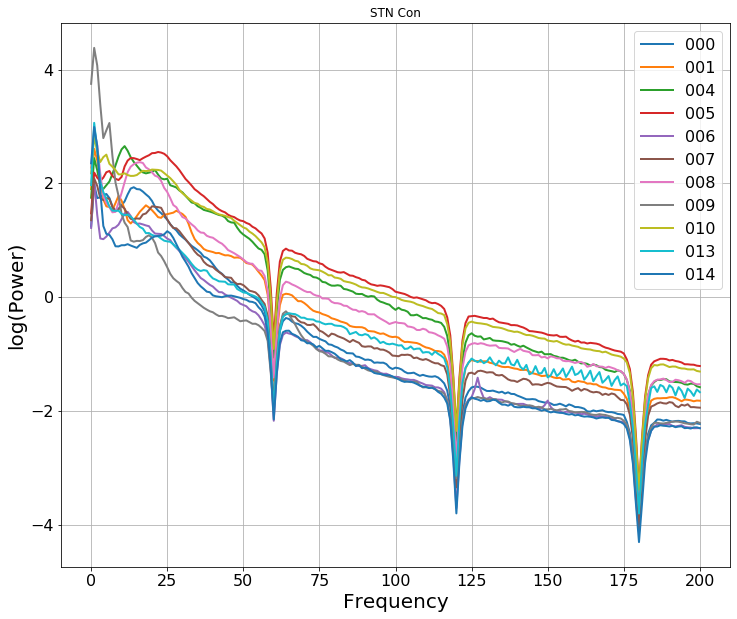

In [20]:
fooof.plts.plot_spectra(freqs, ECOG_Con, \
                             log_powers=True, labels=subject_tf_usage)
plt.title('STN Con')

In [21]:
fm = FOOOF()


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                         

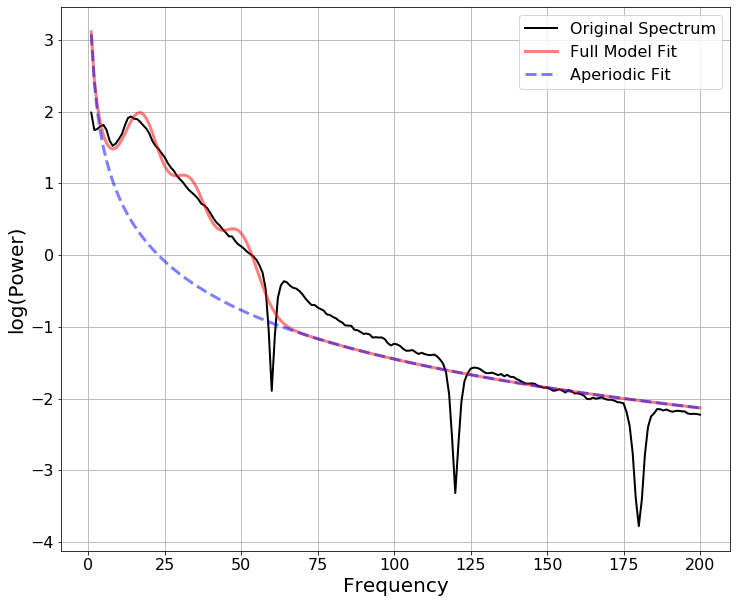

In [24]:
fm.report(freqs, ECOG_Con[0], freq_range=[0, 200])

#### main interest: comparing the aperiodic fit; described by offset and exponent

In [26]:
from fooof import FOOOFGroup

In [99]:
# Initialize a FOOOFGroup object, which accepts all the same settings as FOOOF
fg_ecog_con = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)
fg_ecog_con.fit(freqs, np.array(ECOG_Con), [0, 200])

fg_ecog_ips = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)
fg_ecog_ips.fit(freqs, np.array(ECOG_Ips), [0, 200])

fg_stn_con = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)
fg_stn_con.fit(freqs, np.array(STN_Con), [0, 200])

fg_stn_ips = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)
fg_stn_ips.fit(freqs, np.array(STN_Ips), [0, 200])



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 11 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 11 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Skipping frequency == 0, as this

In [34]:
# Print out results
fg_ecog_con.print_results()

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 11                             
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

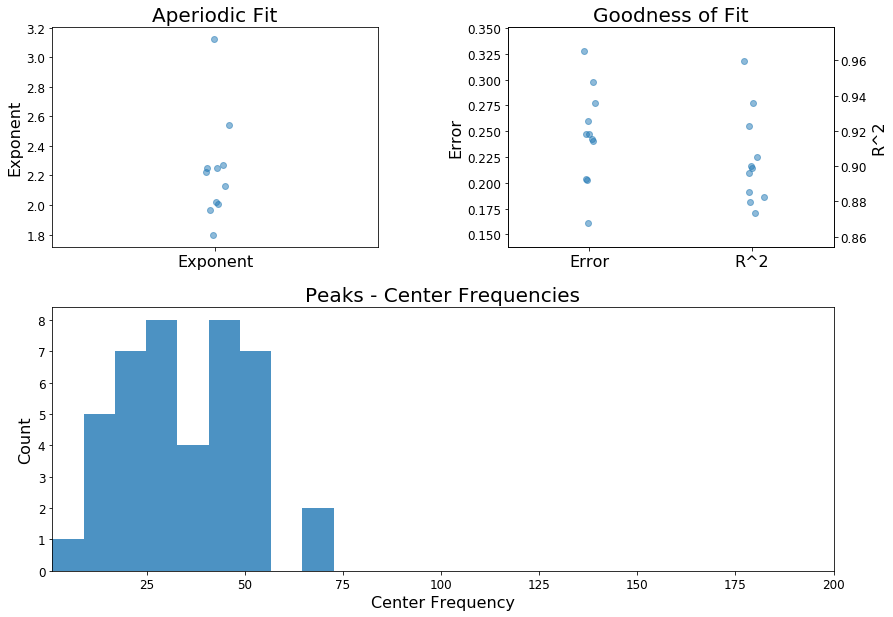

In [35]:
# Plot a summary of the results across the group
fg_ecog_con.plot()

In [45]:
aps1 = fg_ecog_con.get_params('aperiodic_params')
aps2 = fg_stn_con.get_params('aperiodic_params')
colors = ['#2400a8', '#00700b']

Text(0.5, 1.0, 'Contralateral Aperiodic fit')

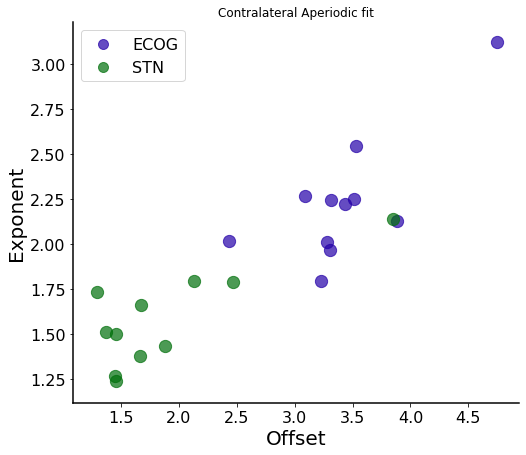

In [48]:
# Compare the aperiodic parameters between groups
aps1 = fg_ecog_con.get_params('aperiodic_params')
aps2 = fg_stn_con.get_params('aperiodic_params')
colors = ['#2400a8', '#00700b']
fooof.plts.aperiodic.plot_aperiodic_params([aps1, aps2], labels=['ECOG', 'STN'], \
                                    colors=colors)
plt.title('Contralateral Aperiodic fit')

Text(0.5, 1.0, 'Ipsilateral Aperiodic fit')

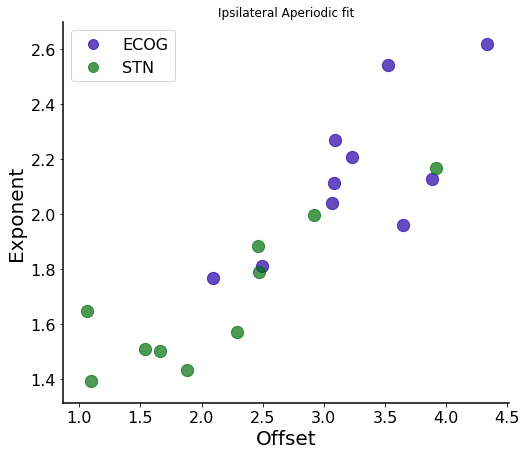

In [49]:
# Compare the aperiodic parameters between groups
aps1 = fg_ecog_ips.get_params('aperiodic_params')
aps2 = fg_stn_ips.get_params('aperiodic_params')
colors = ['#2400a8', '#00700b']
fooof.plts.aperiodic.plot_aperiodic_params([aps1, aps2], labels=['ECOG', 'STN'], \
                                    colors=colors)
plt.title('Ipsilateral Aperiodic fit')

In [88]:
import pickle

In [90]:
with open('res_32_best.p', 'rb') as handle:
    res_32_best = pickle.load(handle)


In [85]:
fg_ecog_con.get_params('aperiodic_params').shape

(11, 2)

In [86]:
fg_ecog_ips.get_params('aperiodic_params').shape

(10, 2)

In [87]:
#question tho, is there a correlation to the performance of those measures? 
fg_ecog_con.get_params('aperiodic_params', 'exponent')

array([2.26955858, 2.2220457 , 1.96704971, 1.7979062 , 2.01958232,
       2.24891797, 2.00991379, 3.12178034, 2.12742585, 2.25121744,
       2.54401655])

#### check Pearson correlation cofficient between Fisher discriminated R² and aperiodic exponent

In [106]:
print('Spearson correlation coefficient of R² and aperiodic exponent: Stat. , P value')
print('ECOG Con')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_ecog_con']), \
                     fg_ecog_con.get_params('aperiodic_params', 'exponent'))) # 0:stat, 1:p
print('ECOG Ips')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_ecog_ips']), \
                     fg_ecog_ips.get_params('aperiodic_params', 'exponent'))) # 0:stat, 1:p

print('STN Con')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_stn_con']), \
                     fg_stn_con.get_params('aperiodic_params', 'exponent'))) # 0:stat, 1:p
print('STN Ips')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_stn_ips']), \
                     fg_stn_ips.get_params('aperiodic_params', 'exponent'))) # 0:stat, 1:p
print(' ')
print('Spearson correlation coefficient of R² and aperiodic opffset: Stat. , P value')
print('ECOG Con')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_ecog_con']), \
                     fg_ecog_con.get_params('aperiodic_params', 'offset'))) # 0:stat, 1:p
print('ECOG Ips')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_ecog_ips']), \
                     fg_ecog_ips.get_params('aperiodic_params', 'offset'))) # 0:stat, 1:p

print('STN Con')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_stn_con']), \
                     fg_stn_con.get_params('aperiodic_params', 'offset'))) # 0:stat, 1:p
print('STN Ips')
print(scipy.stats.pearsonr(np.arctanh(res_32_best['best_stn_ips']), \
                     fg_stn_ips.get_params('aperiodic_params', 'offset'))) # 0:stat, 1:p

Spearson correlation coefficient of R² and aperiodic exponent: Stat. , P value
ECOG Con
(-0.20557004536520296, 0.544249782811758)
ECOG Ips
(-0.2176615867879998, 0.5202698035839266)
STN Con
(0.17638185551413268, 0.6039071241995099)
STN Ips
(-0.07016345541067803, 0.8375795355180062)
 
Spearson correlation coefficient of R² and aperiodic opffset: Stat. , P value
ECOG Con
(-0.2473280270022138, 0.46341910793457924)
ECOG Ips
(-0.22666673593953324, 0.502708118452747)
STN Con
(0.243916653921099, 0.46980708615674543)
STN Ips
(0.08457380374407344, 0.8047288254309652)


#### compare periodic components

In [58]:
from fooof.analysis import get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params

In [62]:
bands = Bands({'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30], 
              'low_gamma' : [60, 80], 
              'high_gamma': [90, 200]})

In [67]:
g1_theta = get_band_peak_fg(fg_ecog_con, bands.theta)
g2_theta = get_band_peak_fg(fg_stn_con, bands.theta)

g1_alpha = get_band_peak_fg(fg_ecog_con, bands.alpha)
g2_alpha = get_band_peak_fg(fg_stn_con, bands.alpha)

g1_beta = get_band_peak_fg(fg_ecog_con, bands.beta)
g2_beta = get_band_peak_fg(fg_stn_con, bands.beta)

g1_lg = get_band_peak_fg(fg_ecog_con, bands.low_gamma)
g2_lg = get_band_peak_fg(fg_stn_con, bands.low_gamma)

g1_hg = get_band_peak_fg(fg_ecog_con, bands.high_gamma)
g2_hg = get_band_peak_fg(fg_stn_con, bands.high_gamma)



Text(0.5, 1.0, 'beta band 4-8 Hz Contralateral movements')

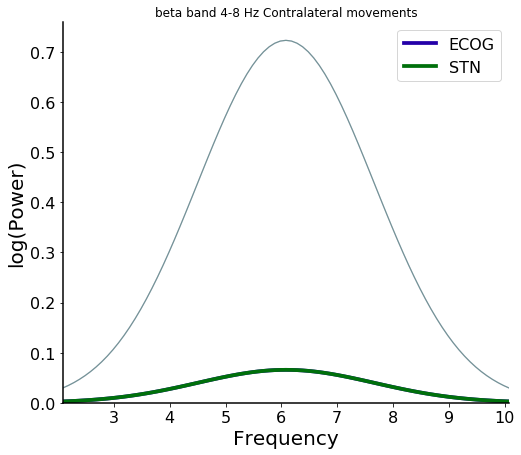

In [69]:
plot_peak_fits([g1_theta, g1_theta],
               labels=['ECOG', 'STN'], colors=colors)
plt.title('beta band 4-8 Hz Contralateral movements')

Text(0.5, 1.0, 'beta band 8-13 Hz Contralateral movements')

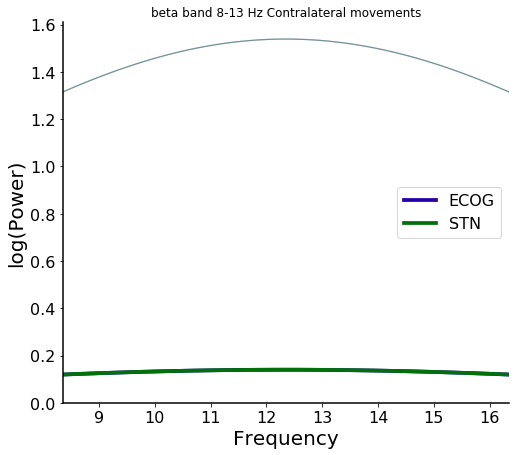

In [68]:
plot_peak_fits([g1_alpha, g1_alpha],
               labels=['ECOG', 'STN'], colors=colors)
plt.title('beta band 8-13 Hz Contralateral movements')

Text(0.5, 1.0, 'beta band 13-30 Hz Contralateral movements')

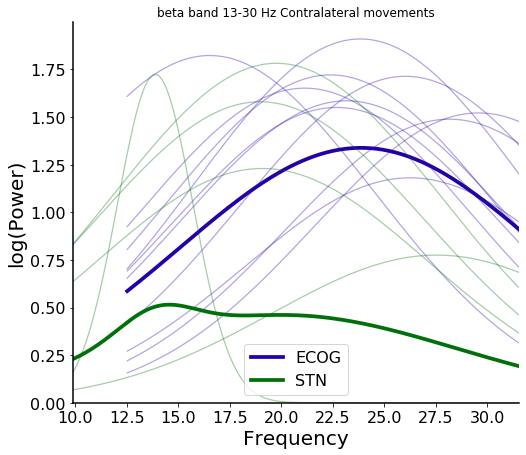

In [61]:
plot_peak_fits([g1_beta, g2_beta],
               labels=['ECOG', 'STN'], colors=colors)
plt.title('beta band 13-30 Hz Contralateral movements')

Text(0.5, 1.0, 'low gamma band 60-80 Hz Contralateral movements')

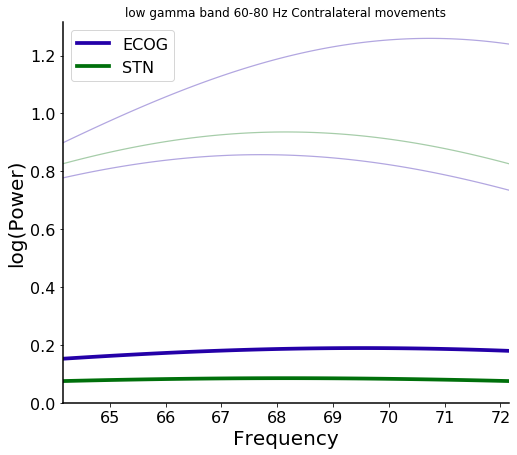

In [65]:
plot_peak_fits([g1_lg, g2_lg],
               labels=['ECOG', 'STN'], colors=colors)
plt.title('low gamma band 60-80 Hz Contralateral movements')

ValueError: zero-size array to reduction operation minimum which has no identity

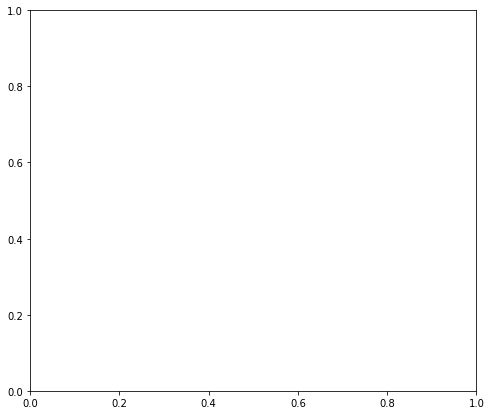

In [66]:
plot_peak_fits([g1_hg, g2_hg],
               labels=['ECOG', 'STN'], colors=colors)
plt.title('low gamma band 90-200 Hz Contralateral movements')

In [36]:
exps = fg_ecog_con.get_params('aperiodic_params', 'exponent')

In [38]:
plt.scatter(fg_ecog_con.get_params('aperiodic_params', 'exponent'), label='ECOG')
plt.scatter(fg_stn_con.get_params('aperiodic_params', 'exponent'), label='STN')


TypeError: scatter() missing 1 required positional argument: 'y'

([<matplotlib.axis.XTick at 0x7f23cd0c3150>,
 <a list of 2 Text xticklabel objects>)

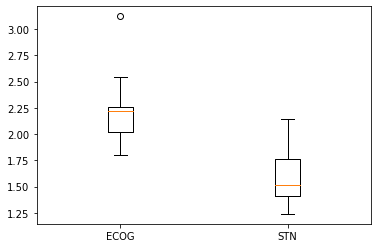

In [40]:
plt.boxplot([fg_ecog_con.get_params('aperiodic_params', 'exponent'), \
        fg_stn_con.get_params('aperiodic_params', 'exponent')])
plt.xticks(np.arange(1,3), ['ECOG', 'STN'])

([<matplotlib.axis.XTick at 0x7f23cc7c1d90>,
 <a list of 2 Text xticklabel objects>)

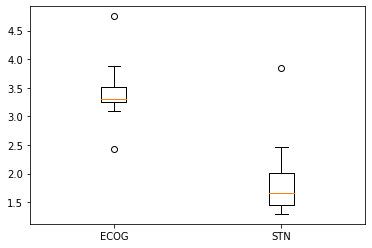

In [41]:
plt.boxplot([fg_ecog_con.get_params('aperiodic_params', 'offset'), \
        fg_stn_con.get_params('aperiodic_params', 'offset')])
plt.xticks(np.arange(1,3), ['ECOG', 'STN'])